# Project description
Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value.
Rusty Bargain is interested in:
- the quality of the prediction
- the speed of the prediction
- the time required for training

# 1. Data preparation

In [1]:
#Import all libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import time
import seaborn as sns   #visualization
sns.set(style="ticks", color_codes=True)

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import RepeatedKFold
import xgboost as xgb
from sklearn.preprocessing import OneHotEncoder
##label encoding the data 
from sklearn.preprocessing import LabelEncoder 

from lightgbm import LGBMRegressor
#from catboost import CatBoostRegressor

from sklearn.metrics import r2_score

import sys
print (sys.version)

#define most used variables
RANDOM_STATE=12345
PRINTING_SEPARATOR = '*' * 100
TARGET = 'Price'
pd.set_option('display.max_colwidth', -1)

3.7.6 | packaged by conda-forge | (default, Jun  1 2020, 18:57:50) 
[GCC 7.5.0]


In [2]:
!pip install catboost

Defaulting to user installation because normal site-packages is not writeable


In [3]:
#I DEFINED A MACRO FOR "PRINT" and "DISPLAY" FUNCTION using DEBUG FLAG
#If DEBUG=0, the PRINT(), DISPLAY() function will print nothing
#If DEBUG=1, the PRINT(), DISPLAY() function will work like the standard functions

def printNothing(*args):
  pass

DEBUG=1
if (DEBUG):
  print('DEBUG ON')
  PRINT = print
  DISPLAY = display
else:
  print('DEBUG OFF')
  PRINT = printNothing
  DISPLAY = printNothing

DEBUG ON


In [4]:
#Use it to print separator between the printing information
def PRINT_SEPARATOR():
  print(PRINTING_SEPARATOR)
  print()

## 1.1 CREATE A RESULTS DATAFRAME

In [5]:
#Create a dataframe to dataframe name, Model name and model results

column_names = ["Model-name","Train-Score","Fit-RunTime (ms)","Predict-RunTime (ms)",'RMSE-RunTime (ms)','RMSE',"Hyper-Parameters"]
##Intitialize lists data. 
df_results = pd.DataFrame(columns = column_names)
display(df_results)

,Model-name,Train-Score,Fit-RunTime (ms),Predict-RunTime (ms),RMSE-RunTime (ms),RMSE,Hyper-Parameters


## 1.2 Data downloading

In [6]:
#Import the file and create the dataset
path = '/datasets'

#Create dataframe to store the source data
dfOriginal = pd.read_csv(path+'/car_data.csv')   #training dataset download

In [7]:
def display_information(df):
    print('Head:')
    print()
    display(df.head())
    PRINT_SEPARATOR()
    print('Info:')
    print()
    display(df.info())
    PRINT_SEPARATOR()
    print('Describe:')
    print()
    display(df.describe())
    PRINT_SEPARATOR()
    print('Skew Factor')
    print(df.skew())
    PRINT_SEPARATOR()
    print('Columns with nulls:')
    display(get_percent_of_na_df(df,4))
    PRINT_SEPARATOR()
    print('Shape:')
    print(df.shape)
    PRINT_SEPARATOR()
    print('Duplicated:')
    print('Duplicate rows:', df.duplicated().sum(), ', Duplicate percentage:', (df.duplicated().sum() * 100 ) /df.shape[0],'%')
    
def get_percent_of_na_df(df,num):
    df_nulls = pd.DataFrame(df.isna().sum(),columns=['Missing Values'])
    df_nulls['Percent of Nulls'] = round(df_nulls['Missing Values'] / df.shape[0],num) *100
    return df_nulls

In [8]:
display_information(dfOriginal)
PRINT_SEPARATOR()

Head:



,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


****************************************************************************************************

Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Mileage              354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


None

****************************************************************************************************

Describe:



,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


****************************************************************************************************

Skew Factor
Price                1.430609 
RegistrationYear     74.621005
Power                60.157196
Mileage             -1.724119 
RegistrationMonth    0.081207 
NumberOfPictures     0.000000 
PostalCode           0.077054 
dtype: float64
****************************************************************************************************

Columns with nulls:


,Missing Values,Percent of Nulls
DateCrawled,0,0.00
Price,0,0.00
VehicleType,37490,10.58
RegistrationYear,0,0.00
Gearbox,19833,5.60
Power,0,0.00
Model,19705,5.56
Mileage,0,0.00
RegistrationMonth,0,0.00
FuelType,32895,9.28


****************************************************************************************************

Shape:
(354369, 16)
****************************************************************************************************

Duplicated:
Duplicate rows: 262 , Duplicate percentage: 0.07393423239617461 %
****************************************************************************************************



## CONCLUSION
- We see 262 duplicated rows, which is 0.07% of the total dataset.
- Remove the duplicated rows and check



## 1.3 DATA PREPROCESSING: Remove Duplicated Rows


In [9]:
df0 = dfOriginal.drop_duplicates()
print(df0.shape)

print('Duplicated:')
print("\033[1m" + 'We have {} duplicated rows.'.format(dfOriginal.duplicated().sum()) + "\033[0m")

(354107, 16)
Duplicated:
We have 262 duplicated rows.


## CONCLUSION
- No more duplicated rows, removed 262 duplicated rows, which is 0.07% of the total dataset.


DATA PREPROCESSING: Identify and remove/fill Nans

In [10]:
listOfFields = df0.columns
for field in listOfFields:
  PRINT_SEPARATOR()
  display(df0[field].value_counts(dropna=False))

****************************************************************************************************



05/03/2016 14:25    66
05/03/2016 14:26    57
16/03/2016 18:49    55
20/03/2016 11:50    54
05/03/2016 14:49    54
                    ..
23/03/2016 19:28    1 
04/04/2016 02:01    1 
18/03/2016 21:09    1 
11/03/2016 08:50    1 
31/03/2016 12:41    1 
Name: DateCrawled, Length: 15470, dtype: int64

****************************************************************************************************



0        10770
500      5667 
1500     5391 
1000     4647 
1200     4589 
         ...  
13440    1    
1414     1    
8069     1    
10370    1    
384      1    
Name: Price, Length: 3731, dtype: int64

****************************************************************************************************



sedan          91399
small          79753
wagon          65115
NaN            37484
bus            28752
convertible    20180
coupe          16147
suv            11991
other          3286 
Name: VehicleType, dtype: int64

****************************************************************************************************



2000    24476
1999    22703
2005    22094
2001    20107
2006    19874
        ...  
3200    1    
1920    1    
1919    1    
1915    1    
8455    1    
Name: RegistrationYear, Length: 151, dtype: int64

****************************************************************************************************



manual    268034
auto      66243 
NaN       19830 
Name: Gearbox, dtype: int64

****************************************************************************************************



0        40218
75       24001
60       15879
150      14571
101      13286
         ...  
16311    1    
1360     1    
1968     1    
6226     1    
6006     1    
Name: Power, Length: 712, dtype: int64

****************************************************************************************************



golf                  29215
other                 24402
3er                   19744
NaN                   19701
polo                  13057
                      ...  
serie_2               8    
rangerover            4    
serie_3               4    
serie_1               2    
range_rover_evoque    2    
Name: Model, Length: 251, dtype: int64

****************************************************************************************************



150000    238042
125000    36424 
100000    14869 
90000     11555 
80000     10036 
70000     8589  
60000     7439  
5000      6396  
50000     6225  
40000     4905  
30000     4434  
20000     3972  
10000     1221  
Name: Mileage, dtype: int64

****************************************************************************************************



0     37347
3     34348
6     31471
4     29246
5     29131
7     27186
10    26076
12    24271
11    24167
9     23798
1     23202
8     22610
2     21254
Name: RegistrationMonth, dtype: int64

****************************************************************************************************



petrol      216161
gasoline    98658 
NaN         32889 
lpg         5307  
cng         565   
hybrid      233   
other       204   
electric    90    
Name: FuelType, dtype: int64

****************************************************************************************************



volkswagen        76960
opel              39902
bmw               36881
mercedes_benz     32025
audi              29439
ford              25163
renault           17915
peugeot           10988
fiat              9634 
seat              6901 
mazda             5611 
skoda             5490 
smart             5241 
citroen           5143 
nissan            4936 
toyota            4601 
hyundai           3583 
sonstige_autos    3373 
volvo             3207 
mini              3201 
mitsubishi        3022 
honda             2817 
kia               2463 
suzuki            2320 
alfa_romeo        2311 
chevrolet         1751 
chrysler          1439 
dacia             898  
daihatsu          806  
subaru            762  
porsche           758  
jeep              677  
trabant           589  
land_rover        545  
daewoo            542  
saab              526  
jaguar            505  
rover             486  
lancia            471  
lada              225  
Name: Brand, dtype: int64

****************************************************************************************************



no     246927
NaN    71145 
yes    36035 
Name: NotRepaired, dtype: int64

****************************************************************************************************



03/04/2016 00:00    13705
04/04/2016 00:00    13301
20/03/2016 00:00    12909
12/03/2016 00:00    12833
21/03/2016 00:00    12681
                    ...  
10/08/2015 00:00    1    
08/01/2016 00:00    1    
09/09/2015 00:00    1    
18/01/2016 00:00    1    
10/11/2015 00:00    1    
Name: DateCreated, Length: 109, dtype: int64

****************************************************************************************************



0    354107
Name: NumberOfPictures, dtype: int64

****************************************************************************************************



10115    819
65428    611
66333    343
32257    316
44145    316
        ... 
72655    1  
29587    1  
29496    1  
38528    1  
17154    1  
Name: PostalCode, Length: 8143, dtype: int64

****************************************************************************************************



07/04/2016 07:16    653
07/04/2016 06:45    646
06/04/2016 09:17    641
06/04/2016 04:45    640
07/04/2016 05:45    639
                   ... 
10/03/2016 11:56    1  
28/03/2016 10:21    1  
10/03/2016 16:52    1  
12/03/2016 10:56    1  
29/03/2016 18:31    1  
Name: LastSeen, Length: 18592, dtype: int64

In [11]:
df0.isna().sum()

DateCrawled          0    
Price                0    
VehicleType          37484
RegistrationYear     0    
Gearbox              19830
Power                0    
Model                19701
Mileage              0    
RegistrationMonth    0    
FuelType             32889
Brand                0    
NotRepaired          71145
DateCreated          0    
NumberOfPictures     0    
PostalCode           0    
LastSeen             0    
dtype: int64

## 1.4 REMOVE OUTLIER RECORDS BASED ON QUANTILES


In [12]:
recordsTotal = df0.shape[0]
Q1 = df0.quantile(0.25)
Q3 = df0.quantile(0.75)
IQR = Q3 - Q1

print(IQR)

#df_out = df0[~((df0 < (Q1 - 1.5 * IQR)) |(df0 > (Q3 + 1.5 * IQR))).any(axis=1)]
df_out = df0[~((df0 < (Q1 - 3 * IQR)) |(df0 > (Q3 + 6 * IQR))).any(axis=1)]

recordsQuantile = df0.shape[0] - df_out.shape[0]
PRINT(recordsQuantile, ' records removed using quantile, which is: ',recordsQuantile*100/recordsTotal , '%' )
DISPLAY('Original skew factor:',df0.skew())
DISPLAY('New Skew factor:', df_out.skew()) 

Price                5350.0 
RegistrationYear     9.0    
Power                74.0   
Mileage              25000.0
RegistrationMonth    6.0    
NumberOfPictures     0.0    
PostalCode           40918.0
dtype: float64
22452  records removed using quantile, which is:  6.340456415716154 %


'Original skew factor:'

Price                1.430729 
RegistrationYear     74.593789
Power                60.140380
Mileage             -1.724262 
RegistrationMonth    0.081302 
NumberOfPictures     0.000000 
PostalCode           0.077137 
dtype: float64

'New Skew factor:'

Price                1.503449
RegistrationYear    -0.170756
Power                0.603224
Mileage             -1.715706
RegistrationMonth    0.074250
NumberOfPictures     0.000000
PostalCode           0.075796
dtype: float64

## 1.5 REMOVE COLUMNS THAT WON'T HELP IN PREDICTION

In [13]:
colsRemove = ['DateCrawled', 'DateCreated', 'LastSeen','NumberOfPictures'] 
df1 = df_out.drop(colsRemove,axis=1)
print(df1.isna().sum())
display(df1.head())

Price                0    
VehicleType          33600
RegistrationYear     0    
Gearbox              16528
Power                0    
Model                16824
Mileage              0    
RegistrationMonth    0    
FuelType             29048
Brand                0    
NotRepaired          65184
PostalCode           0    
dtype: int64


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,70435
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437


## 1.6 PROCESS NaN values (if in many columns)
- Remove rows with Nan values in multiple columns
- Then use ffill and bfill to fill rows with Nan values

In [14]:
dfTest2 = df1.query('VehicleType != VehicleType & Power==0 & RegistrationMonth==0 & NotRepaired != NotRepaired & Gearbox != Gearbox')
DISPLAY(dfTest2.head())
df2 = df1.drop(dfTest2.index)
recordsNan = dfTest2.shape[0]
print(df2.isna().sum())

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
94,8390,NaN,2009,NaN,0,insignia,150000,0,NaN,opel,NaN,29221
309,350,NaN,2017,NaN,0,corsa,150000,0,petrol,opel,NaN,26655
334,0,NaN,2005,NaN,0,polo,150000,0,petrol,volkswagen,NaN,35392
355,1050,NaN,2018,NaN,0,golf,150000,0,NaN,volkswagen,NaN,53567
415,0,NaN,1985,NaN,0,3er,150000,0,NaN,bmw,NaN,85051


Price                0    
VehicleType          29713
RegistrationYear     0    
Gearbox              12641
Power                0    
Model                15585
Mileage              0    
RegistrationMonth    0    
FuelType             25883
Brand                0    
NotRepaired          61297
PostalCode           0    
dtype: int64


In [15]:
## Total records removed
print('Total Records',recordsTotal, 'Quantile Records Removed:', recordsQuantile,'Records Nan removed', recordsNan)
print('%age records removed: ', (recordsQuantile+recordsNan)*100/recordsTotal,'%')

Total Records 354107 Quantile Records Removed: 22452 Records Nan removed 3887
%age records removed:  7.438147226685719 %


In [16]:
df2.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,PostalCode
count,327768.000000,327768.000000,327768.000000,327768.000000,327768.000000,327768.000000
mean,4265.386749,2003.097252,109.291096,134950.742598,5.825474,50609.510852
std,4330.658304,6.606709,62.373921,27479.022890,3.681549,25755.750670
min,0.000000,1972.000000,0.000000,50000.000000,0.000000,1067.000000
25%,1100.000000,1999.000000,73.000000,125000.000000,3.000000,30179.000000
50%,2650.000000,2003.000000,105.000000,150000.000000,6.000000,49477.000000
75%,5999.000000,2007.000000,143.000000,150000.000000,9.000000,71131.000000
max,20000.000000,2019.000000,585.000000,150000.000000,12.000000,99998.000000


In [17]:
df3 = df2.fillna(method='ffill')
df4 = df3.fillna(method='bfill')
#df4 = df2.dropna()
PRINT(df4.isnull().sum())
df4.info()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Mileage              0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
PostalCode           0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
Int64Index: 327768 entries, 0 to 354368
Data columns (total 12 columns):
Price                327768 non-null int64
VehicleType          327768 non-null object
RegistrationYear     327768 non-null int64
Gearbox              327768 non-null object
Power                327768 non-null int64
Model                327768 non-null object
Mileage              327768 non-null int64
RegistrationMonth    327768 non-null int64
FuelType             327768 non-null object
Brand                327768 non-null object
NotRepaired          327768 non-null object
PostalCode           327768 non-null int64
dtypes: int64(6), object(6)
memory usage: 32.5+ MB


In [18]:
print('Original skew:',df0.skew())
print('Final skew:',df4.skew())

Original skew: Price                1.430729 
RegistrationYear     74.593789
Power                60.140380
Mileage             -1.724262 
RegistrationMonth    0.081302 
NumberOfPictures     0.000000 
PostalCode           0.077137 
dtype: float64
Final skew: Price                1.494880
RegistrationYear    -0.172118
Power                0.632299
Mileage             -1.710939
RegistrationMonth    0.066796
PostalCode           0.073439
dtype: float64


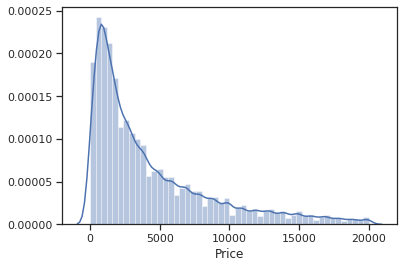

In [19]:
sns.distplot(df4['Price'])
df=df4  #[df4['Price']!=0]  #Final df

## 1.7 EXPLORATORY DATA ANALYSIS
- Heatmap
- Bar Chart

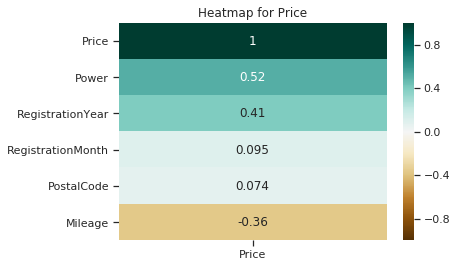

In [20]:
ax = sns.heatmap(df.corr()[[TARGET]].sort_values(by=TARGET, ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
ax.set(title="Heatmap for " + TARGET);

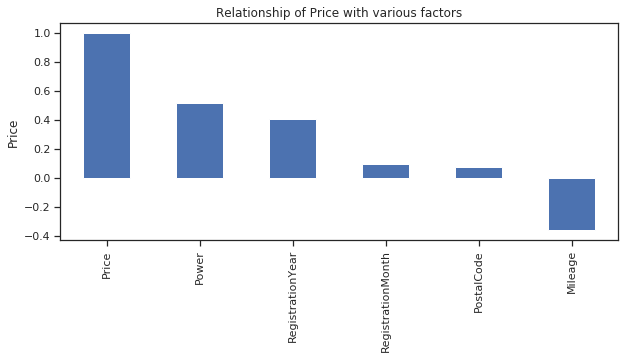

In [21]:
  plt.figure(figsize=(10,4))
  ax = df.corr()[TARGET].sort_values(ascending = False).plot(kind='bar')
  ax.set(title="Relationship of " + TARGET + " with various factors",ylabel=TARGET);

## CONCLUSION
Price has: 
- Strong positive correlation with Power, Registration Year.
- very weak positive correlation with PostalCode and RegistrationMonth .
- Strong negative correlation with Mileage. This is obvious. More the mileage, lower the cost.

# 2. Model training

## 2.1 FEATURE ENGINEERING

In [22]:
features =  df.drop(TARGET , axis=1)
target = df[TARGET]

#SPLIT TRAINING INTO TRAINING (75%) AND VALIDATION_TEST (25%)
features_train, features_test, target_train, target_test = train_test_split(
        features, target, test_size=0.25, random_state=RANDOM_STATE)

totsize = len(df)
PRINT_SEPARATOR()
print('training set  : {0:.0%}'.format(len(features_train) /totsize),features_train.shape, ', training target   :',target_train.shape)
print('test set: {0:.0%}'.format(len(features_test)/totsize),features_test.shape,', test target :',target_test.shape)

****************************************************************************************************

training set  : 75% (245826, 11) , training target   : (245826,)
test set: 25% (81942, 11) , test target : (81942,)


In [23]:
df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Mileage', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired',
       'PostalCode'],
      dtype='object')

In [24]:
##Encode categorical features
from sklearn.preprocessing import OrdinalEncoder
listCategory = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Model', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired', 'PostalCode']

encoder = OrdinalEncoder()

PRINT(df.info())
dfE=df
dfE[listCategory]= encoder.fit_transform(dfE[listCategory])
display(dfE.head())

featuresE =  dfE.drop(TARGET , axis=1)
targetE = dfE[TARGET]

#SPLIT TRAINING INTO TRAINING (75%) AND VALIDATION_TEST (25%)
featuresE_train, featuresE_test, targetE_train, targetE_test = train_test_split(
        featuresE, targetE, test_size=0.25, random_state=RANDOM_STATE)

totsizeE = len(dfE)
PRINT_SEPARATOR()
print('training set  : {0:.0%}'.format(len(featuresE_train) /totsize),featuresE_train.shape, ', training target   :',targetE_train.shape)
print('test set: {0:.0%}'.format(len(featuresE_test)/totsizeE),featuresE_test.shape,', test target :',targetE_test.shape)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 327768 entries, 0 to 354368
Data columns (total 12 columns):
Price                327768 non-null int64
VehicleType          327768 non-null object
RegistrationYear     327768 non-null int64
Gearbox              327768 non-null object
Power                327768 non-null int64
Model                327768 non-null object
Mileage              327768 non-null int64
RegistrationMonth    327768 non-null int64
FuelType             327768 non-null object
Brand                327768 non-null object
NotRepaired          327768 non-null object
PostalCode           327768 non-null int64
dtypes: int64(6), object(6)
memory usage: 32.5+ MB
None


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
0,480,2.0,21.0,1.0,0,116.0,150000,0.0,6.0,38.0,1.0,4892.0
1,18300,2.0,39.0,1.0,190,116.0,125000,5.0,2.0,1.0,1.0,4609.0
2,9800,6.0,32.0,0.0,163,117.0,125000,8.0,2.0,14.0,1.0,6981.0
3,1500,5.0,29.0,1.0,75,116.0,150000,6.0,6.0,38.0,0.0,7021.0
4,3600,5.0,36.0,1.0,69,101.0,90000,7.0,2.0,31.0,0.0,4206.0


****************************************************************************************************

training set  : 75% (245826, 11) , training target   : (245826,)
test set: 25% (81942, 11) , test target : (81942,)


In [25]:
dfPredictions=pd.DataFrame()
dfPredictions['Actual']=target_test

##RMSE. Define a function to score RMSE
##sklearn.metrics has a mean_squared_error function with a squared kwarg (defaults to True). Setting squared to False will return the RMSE.
def rmse_scorer(target: np.ndarray, predicted: np.ndarray):
    return np.sqrt(mean_squared_error(target, predicted))
    
#map rmse_scoring - to be used in model scoring for GridSearchCV.   
rmse_scoring = make_scorer(rmse_scorer,greater_is_better=False)

## 2.2 LINEAR REGRESSION

In [26]:
def updateResults(model_name,hyperParam,score,resultFit,resultPredict,resultRMSE,rmseModel,df_results):
    resultRowStr= [model_name,score,resultFit,resultPredict,resultRMSE,rmseModel,hyperParam]
    #print(resultRowStr,df_results.columns)

    rows = [pd.Series(resultRowStr, index=df_results.columns)]
    ##append the rows
    df_results=df_results.append(rows,ignore_index=True)
    
    ##check the rows 
    display(df_results)
    return(df_results)

In [27]:
def timesOfModel(model1,features_train1,target_train1,features_test1,target_test1):
    startFit=time.time()
    model1.fit(features_train1, target_train1)
    timeFit=time.time()-startFit

    startPredict = time.time()
    predicted_test = model1.predict(features_test1)
    timePredict=time.time() - startPredict

    startRMSE=time.time()
    rmseModel = rmse_scorer(target_test1, predicted_test) 
    timeRMSE=time.time()-startRMSE

    return(predicted_test, timeFit*1000,timePredict*1000,timeRMSE*1000,rmseModel)

In [28]:
##Linear Regression
modelName="LinearRegression"
hyperParam = "none"
model = LinearRegression()

score = cross_val_score(model, featuresE_train, targetE_train , scoring=rmse_scoring,cv=2)
predicted, timeFit,timePredict,timeRMSE,rmseModel = timesOfModel(model,featuresE_train, targetE_train,featuresE_test,targetE_test)
dfPredictions[modelName]=predicted

df_results = updateResults(modelName,hyperParam,score.mean(),timeFit,timePredict,timeRMSE,rmseModel,df_results)

,Model-name,Train-Score,Fit-RunTime (ms),Predict-RunTime (ms),RMSE-RunTime (ms),RMSE,Hyper-Parameters
0,LinearRegression,-2918.223238,213.126183,3.970385,1.332998,2913.33146,none


## 2.3 RANDOM FOREST REGRESSOR

In [29]:
for depth in range(1, 10, 1): 
    model = RandomForestRegressor(n_estimators=30, max_depth=depth, random_state = RANDOM_STATE)
    score = cross_val_score(model, featuresE_train, targetE_train, scoring=rmse_scoring, cv=5)
    print('Max_Depth=', depth, ':', score.mean())

Max_Depth= 1 : -3645.3292244665026
Max_Depth= 2 : -3103.4184354492263
Max_Depth= 3 : -2855.8030429417
Max_Depth= 4 : -2582.993598467686
Max_Depth= 5 : -2414.742750827724
Max_Depth= 6 : -2263.6586380513545
Max_Depth= 7 : -2153.1015870692254
Max_Depth= 8 : -2071.2833268121963
Max_Depth= 9 : -1993.3766859733107


In [30]:
model = RandomForestRegressor(n_estimators=30, max_depth=9, random_state=RANDOM_STATE)
predicted, timeFit,timePredict,timeRMSE,rmseModel = timesOfModel(model,featuresE_train, targetE_train,featuresE_test,targetE_test)

In [31]:
modelName = "RandomForestRegressor"
hyperParam = 'Max_Depth = 9'
dfPredictions[modelName]=predicted
df_results = updateResults(modelName,hyperParam,score.mean(),timeFit,timePredict,timeRMSE,rmseModel,df_results)

,Model-name,Train-Score,Fit-RunTime (ms),Predict-RunTime (ms),RMSE-RunTime (ms),RMSE,Hyper-Parameters
0,LinearRegression,-2918.223238,213.126183,3.970385,1.332998,2913.331460,none
1,RandomForestRegressor,-1993.376686,14926.349640,215.947151,0.814199,1974.667199,Max_Depth = 9


## 2.4 DECISION TREE REGRESSOR

In [32]:
##Decision Tree Regressor
for depth in range(1,10):
    model = DecisionTreeRegressor(max_depth=depth, random_state=RANDOM_STATE)
    score = cross_val_score(model, featuresE_train, targetE_train, scoring=rmse_scoring, cv=5)
    print('Max_Depth=', depth, ':', score.mean())

Max_Depth= 1 : -3645.3360478918185
Max_Depth= 2 : -3122.055398002115
Max_Depth= 3 : -2876.9261524919875
Max_Depth= 4 : -2609.145666000958
Max_Depth= 5 : -2450.151706163441
Max_Depth= 6 : -2300.85248309925
Max_Depth= 7 : -2199.666232735684
Max_Depth= 8 : -2130.365927705179
Max_Depth= 9 : -2074.1583974184864


In [33]:
model = DecisionTreeRegressor(max_depth=9, random_state=RANDOM_STATE)
predicted, timeFit,timePredict,timeRMSE,rmseModel = timesOfModel(model,featuresE_train, targetE_train,featuresE_test,targetE_test)

In [34]:
modelName = "DecisionTreeRegressor"
hyperParam = 'Max_Depth = 9'

dfPredictions[modelName]=predicted
df_results = updateResults(modelName,hyperParam,score.mean(),timeFit,timePredict,timeRMSE,rmseModel,df_results)

,Model-name,Train-Score,Fit-RunTime (ms),Predict-RunTime (ms),RMSE-RunTime (ms),RMSE,Hyper-Parameters
0,LinearRegression,-2918.223238,213.126183,3.970385,1.332998,2913.331460,none
1,RandomForestRegressor,-1993.376686,14926.349640,215.947151,0.814199,1974.667199,Max_Depth = 9
2,DecisionTreeRegressor,-2074.158397,753.551483,10.897875,0.885725,2052.243639,Max_Depth = 9


## 2.5 CatBoost Regressor with Ordinal Encoding

In [35]:

##Setting up parameters for gridsearch
from catboost import CatBoostRegressor
model = CatBoostRegressor()
parameters = {'depth' : [6,8,10], 
              'learning_rate' : [0.5,0.1],
              'l2_leaf_reg' : [2,4],
              'iterations' : [10],
              'metric_period' : [10],
              'random_state' : [RANDOM_STATE],
              'eval_metric':['RMSE']}
grid = GridSearchCV(estimator=model, param_grid = parameters, scoring=rmse_scoring, cv = 3, n_jobs=-1, verbose=1)
grid.fit(featuresE_train, targetE_train)
best_param = grid.best_params_
print("\n The best score across ALL searched params:\n",
          grid.best_score_)
    
print("\n The best parameters across ALL searched params:\n",
          grid.best_params_)

##Specify the training parameters 
model = CatBoostRegressor(iterations=1000, 
                          depth=best_param['depth'], 
                          learning_rate=best_param['learning_rate'],
                          l2_leaf_reg = best_param['l2_leaf_reg'],
                          metric_period=50,
                          eval_metric='RMSE',
                          random_state=RANDOM_STATE)

predicted, timeFit,timePredict,timeRMSE,rmseModel = timesOfModel(model,featuresE_train, targetE_train,featuresE_test,targetE_test)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


0:	learn: 3162.0657282	total: 90.8ms	remaining: 817ms
9:	learn: 1984.6663898	total: 1.19s	remaining: 0us
0:	learn: 3167.7874945	total: 102ms	remaining: 915ms
9:	learn: 1988.3808354	total: 1.2s	remaining: 0us
0:	learn: 3165.1613301	total: 25.8ms	remaining: 232ms
9:	learn: 1988.7779197	total: 1.13s	remaining: 0us
0:	learn: 4063.1663283	total: 103ms	remaining: 923ms
9:	learn: 2688.3804232	total: 1.21s	remaining: 0us
0:	learn: 4075.8706560	total: 34.5ms	remaining: 311ms
9:	learn: 2704.3389760	total: 1.13s	remaining: 0us
0:	learn: 4069.8683996	total: 16.9ms	remaining: 152ms
9:	learn: 2707.8909835	total: 1.11s	remaining: 0us
0:	learn: 3162.5909675	total: 17.7ms	remaining: 159ms
9:	learn: 1985.1392041	total: 1.12s	remaining: 0us
0:	learn: 3168.3132073	total: 72.9ms	remaining: 656ms
9:	learn: 1991.0447487	total: 1.17s	remaining: 0us
0:	learn: 3165.7668587	total: 64.7ms	remaining: 582ms
9:	learn: 1983.1064780	total: 1.26s	remaining: 0us
0:	learn: 4063.3131510	total: 35.3ms	remaining: 318ms
9:	l

[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  1.9min finished


0:	learn: 2988.5953458	total: 182ms	remaining: 1.64s
9:	learn: 1837.4540168	total: 2.87s	remaining: 0us

 The best score across ALL searched params:
 -1867.61960482278

 The best parameters across ALL searched params:
 {'depth': 10, 'eval_metric': 'RMSE', 'iterations': 10, 'l2_leaf_reg': 4, 'learning_rate': 0.5, 'metric_period': 10, 'random_state': 12345}
0:	learn: 2988.5953458	total: 196ms	remaining: 3m 16s
50:	learn: 1622.2337056	total: 14.5s	remaining: 4m 29s
100:	learn: 1519.7619139	total: 29s	remaining: 4m 17s
150:	learn: 1448.6551519	total: 43.4s	remaining: 4m 4s
200:	learn: 1388.1220988	total: 57.7s	remaining: 3m 49s
250:	learn: 1343.4055447	total: 1m 12s	remaining: 3m 35s
300:	learn: 1305.4175342	total: 1m 26s	remaining: 3m 20s
350:	learn: 1268.9838904	total: 1m 40s	remaining: 3m 6s
400:	learn: 1238.7023964	total: 1m 54s	remaining: 2m 51s
450:	learn: 1209.2513377	total: 2m 9s	remaining: 2m 37s
500:	learn: 1182.7912569	total: 2m 23s	remaining: 2m 22s
550:	learn: 1158.5891649	tot

In [36]:
modelName = 'CatBoost Enc'

dfPredictions[modelName]=predicted
df_results = updateResults(modelName,best_param,grid.best_score_,timeFit,timePredict,timeRMSE,rmseModel,df_results)

,Model-name,Train-Score,Fit-RunTime (ms),Predict-RunTime (ms),RMSE-RunTime (ms),RMSE,Hyper-Parameters
0,LinearRegression,-2918.223238,213.126183,3.970385,1.332998,2913.331460,none
1,RandomForestRegressor,-1993.376686,14926.349640,215.947151,0.814199,1974.667199,Max_Depth = 9
2,DecisionTreeRegressor,-2074.158397,753.551483,10.897875,0.885725,2052.243639,Max_Depth = 9
3,CatBoost Enc,-1867.619605,288657.253265,683.476925,1.041174,1655.173732,"{'depth': 10, 'eval_metric': 'RMSE', 'iterations': 10, 'l2_leaf_reg': 4, 'learning_rate': 0.5, 'metric_period': 10, 'random_state': 12345}"


## 2.6 LightGBM with Ordinal Encoding

In [37]:
##Setting up parameters for gridsearch
model = LGBMRegressor()
parameters = {'num_leaves' : [10,20,30], 
              'learning_rate' : [0.5,0.1],
              'n_estimators' : [10,20],
              'eval_metric':['RMSE'],
              'random_state' : [RANDOM_STATE]
           }
grid = GridSearchCV(estimator=model, param_grid = parameters, scoring=rmse_scoring, cv = 3, n_jobs=-1)
grid.fit(featuresE_train, targetE_train)
best_param = grid.best_params_

print("\n The best score across ALL searched params:\n",
          grid.best_score_)
    
print("\n The best parameters across ALL searched params:\n",
          grid.best_params_)

##Specify the training parameters 
model = LGBMRegressor(num_leaves=best_param['num_leaves'], 
                          learning_rate=best_param['learning_rate'], 
                          n_estimators=100,
                          eval_metric='RMSE',
                          random_state = best_param['random_state'])

predicted, timeFit,timePredict,timeRMSE,rmseModel = timesOfModel(model,featuresE_train, targetE_train,featuresE_test,targetE_test)


 The best score across ALL searched params:
 -1816.141077838079

 The best parameters across ALL searched params:
 {'eval_metric': 'RMSE', 'learning_rate': 0.5, 'n_estimators': 20, 'num_leaves': 30, 'random_state': 12345}


In [38]:
modelName='LightGBM Enc'
dfPredictions[modelName]=predicted
df_results = updateResults(modelName,best_param,grid.best_score_,timeFit,timePredict,timeRMSE,rmseModel,df_results)

,Model-name,Train-Score,Fit-RunTime (ms),Predict-RunTime (ms),RMSE-RunTime (ms),RMSE,Hyper-Parameters
0,LinearRegression,-2918.223238,213.126183,3.970385,1.332998,2913.331460,none
1,RandomForestRegressor,-1993.376686,14926.349640,215.947151,0.814199,1974.667199,Max_Depth = 9
2,DecisionTreeRegressor,-2074.158397,753.551483,10.897875,0.885725,2052.243639,Max_Depth = 9
3,CatBoost Enc,-1867.619605,288657.253265,683.476925,1.041174,1655.173732,"{'depth': 10, 'eval_metric': 'RMSE', 'iterations': 10, 'l2_leaf_reg': 4, 'learning_rate': 0.5, 'metric_period': 10, 'random_state': 12345}"
4,LightGBM Enc,-1816.141078,8701.848269,602.875948,1.307249,1697.628156,"{'eval_metric': 'RMSE', 'learning_rate': 0.5, 'n_estimators': 20, 'num_leaves': 30, 'random_state': 12345}"


##  2.7 CatBoostRegressor without Ordinal Encoding 

model = CatBoostRegressor()
parameters = {'depth' : [6,8,10], 
              'learning_rate' : [0.5,0.1],
              'l2_leaf_reg' : [2,4],
              'metric_period':[10],
              'iterations' : [10],
              'eval_metric':['RMSE'],
              'random_state' : [RANDOM_STATE]}
grid = GridSearchCV(estimator=model, param_grid = parameters, scoring=rmse_scoring, cv = 3, n_jobs=-1, verbose=1)
grid.fit(features_train, target_train, cat_features=listCategory)
best_param = grid.best_params_
print("\n The best score across ALL searched params:\n",
          grid.best_score_)
    
print("\n The best parameters across ALL searched params:\n",
          grid.best_params_)

##Specify the training parameters 
model = CatBoostRegressor(iterations=1000, 
                          depth=best_param['depth'], 
                          learning_rate=best_param['learning_rate'],
                          l2_leaf_reg = best_param['l2_leaf_reg'],
                          eval_metric='RMSE',
                          random_state=RANDOM_STATE,
                          metric_period=50)


startFit=time.time()
model.fit(features_train, target_train, cat_features=listCategory, verbose=False, plot=False)
timeFit=1000*(time.time()-startFit)

startPredict = time.time()
predicted_test = model.predict(features_test)
timePredict=1000*(time.time() - startPredict)

startRMSE=time.time()
rmseModel = rmse_scorer(target_test, predicted_test) 
timeRMSE=1000*(time.time()-startRMSE)

modelName='CatBoost NoEnc'
dfPredictions[modelName]=predicted_test
df_results = updateResults(modelName,best_param,grid.best_score_,timeFit,timePredict,timeRMSE,rmseModel,df_results)

## 2.8 LightGBM Regressor without Ordinal Encoding

In [39]:
for c in listCategory:
    features_train[c] = features_train[c].astype('category')
    features_test[c] = features_test[c].astype('category')

##Setting up parameters for gridsearch
model = LGBMRegressor()
parameters = {'num_leaves' : [10,20,30], 
              'learning_rate' : [0.5,0.1],
              'n_estimators' : [10],
              'eval_metric':['RMSE'],
              'random_state' : [RANDOM_STATE]}
grid = GridSearchCV(estimator=model, param_grid = parameters, scoring=rmse_scoring, cv = 3, n_jobs=-1)
grid.fit(features_train, target_train, categorical_feature = listCategory)
best_param = grid.best_params_

print("\n The best score across ALL searched params:\n",
          grid.best_score_)
    
print("\n The best parameters across ALL searched params:\n",
          grid.best_params_)

##Specify the training parameters 
model = LGBMRegressor(num_leaves=best_param['num_leaves'], 
                          learning_rate=best_param['learning_rate'], 
                          n_estimators=100,
                          eval_metric = 'RMSE',
                          random_state = RANDOM_STATE
                         )

predicted, timeFit,timePredict,timeRMSE,rmseModel = timesOfModel(model,features_train, target_train,features_test,target_test)


 The best score across ALL searched params:
 -1807.504736555936

 The best parameters across ALL searched params:
 {'eval_metric': 'RMSE', 'learning_rate': 0.5, 'n_estimators': 10, 'num_leaves': 30, 'random_state': 12345}


In [40]:
modelName='LightGBM NoEnc'
dfPredictions[modelName]=predicted

df_results = updateResults(modelName,best_param,grid.best_score_,timeFit,timePredict,timeRMSE,rmseModel,df_results)

,Model-name,Train-Score,Fit-RunTime (ms),Predict-RunTime (ms),RMSE-RunTime (ms),RMSE,Hyper-Parameters
0,LinearRegression,-2918.223238,213.126183,3.970385,1.332998,2913.331460,none
1,RandomForestRegressor,-1993.376686,14926.349640,215.947151,0.814199,1974.667199,Max_Depth = 9
2,DecisionTreeRegressor,-2074.158397,753.551483,10.897875,0.885725,2052.243639,Max_Depth = 9
3,CatBoost Enc,-1867.619605,288657.253265,683.476925,1.041174,1655.173732,"{'depth': 10, 'eval_metric': 'RMSE', 'iterations': 10, 'l2_leaf_reg': 4, 'learning_rate': 0.5, 'metric_period': 10, 'random_state': 12345}"
4,LightGBM Enc,-1816.141078,8701.848269,602.875948,1.307249,1697.628156,"{'eval_metric': 'RMSE', 'learning_rate': 0.5, 'n_estimators': 20, 'num_leaves': 30, 'random_state': 12345}"
5,LightGBM NoEnc,-1807.504737,18907.879114,1496.854544,1.317024,1701.224634,"{'eval_metric': 'RMSE', 'learning_rate': 0.5, 'n_estimators': 10, 'num_leaves': 30, 'random_state': 12345}"


## 2.9 XGBoostRegressor
- We already have the ordinal encoded features. We will use DMatrix on them.

In [41]:
display(df.head)
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBRegressor
##Encode categorical features
#listCategory = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Model', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired', 'PostalCode']

encoder =  OneHotEncoder(categories=listCategory, sparse=False)

dftmp=df.astype(int)
display(dftmp.head(5))
dfOHE = dftmp
featuresOHE =  dfOHE.drop(TARGET , axis=1)
targetOHE = dfOHE[TARGET]

##Apply OneHotEncoder to categorical columns - output is no longer a dataframe: df_encoded
tmp=featuresOHE[listCategory]
#tmp = encoder.fit_transform(tmp).toarray()
#print(tmp)
#One hot encoding gave errors so I decided to use Ordinally Encoded dataset.
#I will check it against the 'XGB.cv' results to see if results were good.

#SPLIT TRAINING INTO TRAINING (75%) AND VALIDATION_TEST (25%)
featuresOHE_train, featuresOHE_test, targetOHE_train, targetOHE_test = train_test_split(
        featuresOHE, targetOHE, test_size=0.25, random_state=RANDOM_STATE)

<bound method NDFrame.head of         Price  VehicleType  RegistrationYear  Gearbox  Power  Model  Mileage  \
0       480    2.0          21.0              1.0      0      116.0  150000    
1       18300  2.0          39.0              1.0      190    116.0  125000    
2       9800   6.0          32.0              0.0      163    117.0  125000    
3       1500   5.0          29.0              1.0      75     116.0  150000    
4       3600   5.0          36.0              1.0      69     101.0  90000     
...      ...   ...           ...              ...      ..       ...    ...     
354363  1150   0.0          28.0              1.0      0      248.0  150000    
354364  0      0.0          33.0              1.0      0      78.0   150000    
354366  1199   1.0          28.0              0.0      101    106.0  125000    
354367  9200   0.0          24.0              1.0      102    223.0  150000    
354368  3400   7.0          30.0              1.0      100    116.0  150000    

        R

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
0,480,2,21,1,0,116,150000,0,6,38,1,4892
1,18300,2,39,1,190,116,125000,5,2,1,1,4609
2,9800,6,32,0,163,117,125000,8,2,14,1,6981
3,1500,5,29,1,75,116,150000,6,6,38,0,7021
4,3600,5,36,1,69,101,90000,7,2,31,0,4206


## 2.10 Evaluate Best scoring using xgb.cv

In [42]:
featuresOHE_dmatrix = xgb.DMatrix(data=featuresE,label=targetE)
#k-fold Cross Validation using XGBoost
model=XGBRegressor()
params = {'nthread': 4,'colsample_bytree': 0.7,'learning_rate': 0.07,'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 500,
           'alpha': 10,'seed':RANDOM_STATE,'nfold':3,'num_boost_round':50,
          'early_stopping_rounds':10,'metrics':"rmse",'silent': 1, 'subsample': 0.7}
scores = xgb.cv(dtrain=featuresOHE_dmatrix, params=params, nfold=3,
                    num_boost_round=50,early_stopping_rounds=10,metrics="rmse", as_pandas=True, seed=RANDOM_STATE)
display(scores.min())

train-rmse-mean    1795.852295
train-rmse-std     4.607737   
test-rmse-mean     1826.771322
test-rmse-std      1.612413   
dtype: float64

## 2.11 XGB Regressor

In [43]:
##Specify the training parameters 
model =  XGBRegressor( colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 100)

predicted, timeFit,timePredict,timeRMSE,rmseModel = timesOfModel(model,featuresOHE_train, targetOHE_train,featuresOHE_test,targetOHE_test)

[14:21:52] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [44]:
modelName='XGBRegressor'
hyperParam="colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 100"
dfPredictions[modelName]=predicted

df_results = updateResults(modelName,hyperParam,"-",timeFit,timePredict,timeRMSE,rmseModel,df_results)

,Model-name,Train-Score,Fit-RunTime (ms),Predict-RunTime (ms),RMSE-RunTime (ms),RMSE,Hyper-Parameters
0,LinearRegression,-2918.22,213.126183,3.970385,1.332998,2913.331460,none
1,RandomForestRegressor,-1993.38,14926.349640,215.947151,0.814199,1974.667199,Max_Depth = 9
2,DecisionTreeRegressor,-2074.16,753.551483,10.897875,0.885725,2052.243639,Max_Depth = 9
3,CatBoost Enc,-1867.62,288657.253265,683.476925,1.041174,1655.173732,"{'depth': 10, 'eval_metric': 'RMSE', 'iterations': 10, 'l2_leaf_reg': 4, 'learning_rate': 0.5, 'metric_period': 10, 'random_state': 12345}"
4,LightGBM Enc,-1816.14,8701.848269,602.875948,1.307249,1697.628156,"{'eval_metric': 'RMSE', 'learning_rate': 0.5, 'n_estimators': 20, 'num_leaves': 30, 'random_state': 12345}"
5,LightGBM NoEnc,-1807.5,18907.879114,1496.854544,1.317024,1701.224634,"{'eval_metric': 'RMSE', 'learning_rate': 0.5, 'n_estimators': 10, 'num_leaves': 30, 'random_state': 12345}"
6,XGBRegressor,-,14363.831520,505.872011,1.080751,1822.092082,"colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 100"


## 2.12 XGB Regressor with GridSearchCV

In [45]:
model = XGBRegressor()

##Setting up parameters for gridsearch
parameters = {'nthread':[4], #when use hyperthread, xgboost may become slower
              'learning_rate': [0.05, .07], #so called `eta` value
              'max_depth': [6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [50],
              'random_state':[RANDOM_STATE]}

grid = GridSearchCV(estimator=model,
                        param_grid=parameters,
                        scoring=rmse_scoring,
                        cv = 2,
                        n_jobs = 5,
                        verbose=1)

grid.fit(featuresOHE_train, targetOHE_train)
best_param = grid.best_params_

print("\n The best score across ALL searched params:\n",
          grid.best_score_)
    
print("\n The best parameters across ALL searched params:\n",
         best_param)

##Specify the training parameters 
model = XGBRegressor(
                      nthread=best_param['nthread'],
                      max_depth= best_param['max_depth'],
                      min_child_weight= best_param['min_child_weight'],
                      silent= best_param['silent'],
                      subsample= best_param['subsample'],
                      colsample_bytree= best_param['colsample_bytree'],
                      learning_rate=best_param['learning_rate'], 
                      n_estimators=500,
                      random_state = RANDOM_STATE,
                     )

predicted, timeFit,timePredict,timeRMSE,rmseModel = timesOfModel(model,featuresOHE_train, targetOHE_train,featuresOHE_test,targetOHE_test)

Fitting 2 folds for each of 4 candidates, totalling 8 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done   8 out of   8 | elapsed:  3.5min remaining:    0.0s
[Parallel(n_jobs=5)]: Done   8 out of   8 | elapsed:  3.5min finished



 The best score across ALL searched params:
 -1845.6173101001664

 The best parameters across ALL searched params:
 {'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 50, 'nthread': 4, 'random_state': 12345, 'silent': 1, 'subsample': 0.7}


In [46]:
modelName='XGBoost with GridSearchCV'
dfPredictions[modelName]=predicted

df_results = updateResults(modelName,best_param,grid.best_score_,timeFit,timePredict,timeRMSE,rmseModel,df_results)

,Model-name,Train-Score,Fit-RunTime (ms),Predict-RunTime (ms),RMSE-RunTime (ms),RMSE,Hyper-Parameters
0,LinearRegression,-2918.22,213.126183,3.970385,1.332998,2913.331460,none
1,RandomForestRegressor,-1993.38,14926.349640,215.947151,0.814199,1974.667199,Max_Depth = 9
2,DecisionTreeRegressor,-2074.16,753.551483,10.897875,0.885725,2052.243639,Max_Depth = 9
3,CatBoost Enc,-1867.62,288657.253265,683.476925,1.041174,1655.173732,"{'depth': 10, 'eval_metric': 'RMSE', 'iterations': 10, 'l2_leaf_reg': 4, 'learning_rate': 0.5, 'metric_period': 10, 'random_state': 12345}"
4,LightGBM Enc,-1816.14,8701.848269,602.875948,1.307249,1697.628156,"{'eval_metric': 'RMSE', 'learning_rate': 0.5, 'n_estimators': 20, 'num_leaves': 30, 'random_state': 12345}"
5,LightGBM NoEnc,-1807.5,18907.879114,1496.854544,1.317024,1701.224634,"{'eval_metric': 'RMSE', 'learning_rate': 0.5, 'n_estimators': 10, 'num_leaves': 30, 'random_state': 12345}"
6,XGBRegressor,-,14363.831520,505.872011,1.080751,1822.092082,"colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 100"
7,XGBoost with GridSearchCV,-1845.62,252299.439907,6244.969606,1.467228,1628.258792,"{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 50, 'nthread': 4, 'random_state': 12345, 'silent': 1, 'subsample': 0.7}"


# 3. Model analysis

In [47]:
display(dfPredictions.describe())
PRINT_SEPARATOR()
display(df_results)
PRINT_SEPARATOR()

,Actual,LinearRegression,RandomForestRegressor,DecisionTreeRegressor,CatBoost Enc,LightGBM Enc,LightGBM NoEnc,XGBRegressor,XGBoost with GridSearchCV
count,81942.000000,81942.000000,81942.000000,81942.000000,81942.000000,81942.000000,81942.000000,81942.000000,81942.000000
mean,4249.435393,4252.000457,4252.882536,4256.178166,4251.551624,4250.191516,4248.051310,4245.242188,4250.749512
std,4321.121863,3193.089468,3787.752535,3835.024384,4081.519556,4002.416588,4048.066254,3781.855225,3980.468750
min,0.000000,-5800.014626,465.196854,0.000000,-3877.500798,-1125.943714,-2288.937040,-764.520935,-1024.559814
25%,1100.000000,1812.996725,1538.701426,1570.416684,1263.133255,1303.722433,1293.780714,1372.973755,1313.857666
50%,2600.000000,4029.709142,2847.703049,2768.640930,2727.114608,2733.950132,2759.151722,2964.702637,2766.521973
75%,5999.000000,6423.188506,5674.331926,5566.801440,5958.414965,5930.977091,5963.477156,6065.398438,5929.219849
max,20000.000000,24098.582094,16655.086093,19500.000000,22662.592467,22515.448322,21771.846633,20485.470703,20740.552734


****************************************************************************************************



,Model-name,Train-Score,Fit-RunTime (ms),Predict-RunTime (ms),RMSE-RunTime (ms),RMSE,Hyper-Parameters
0,LinearRegression,-2918.22,213.126183,3.970385,1.332998,2913.331460,none
1,RandomForestRegressor,-1993.38,14926.349640,215.947151,0.814199,1974.667199,Max_Depth = 9
2,DecisionTreeRegressor,-2074.16,753.551483,10.897875,0.885725,2052.243639,Max_Depth = 9
3,CatBoost Enc,-1867.62,288657.253265,683.476925,1.041174,1655.173732,"{'depth': 10, 'eval_metric': 'RMSE', 'iterations': 10, 'l2_leaf_reg': 4, 'learning_rate': 0.5, 'metric_period': 10, 'random_state': 12345}"
4,LightGBM Enc,-1816.14,8701.848269,602.875948,1.307249,1697.628156,"{'eval_metric': 'RMSE', 'learning_rate': 0.5, 'n_estimators': 20, 'num_leaves': 30, 'random_state': 12345}"
5,LightGBM NoEnc,-1807.5,18907.879114,1496.854544,1.317024,1701.224634,"{'eval_metric': 'RMSE', 'learning_rate': 0.5, 'n_estimators': 10, 'num_leaves': 30, 'random_state': 12345}"
6,XGBRegressor,-,14363.831520,505.872011,1.080751,1822.092082,"colsample_bytree = 0.3, learning_rate = 0.1, max_depth = 5, alpha = 10, n_estimators = 100"
7,XGBoost with GridSearchCV,-1845.62,252299.439907,6244.969606,1.467228,1628.258792,"{'colsample_bytree': 0.7, 'learning_rate': 0.07, 'max_depth': 7, 'min_child_weight': 4, 'n_estimators': 50, 'nthread': 4, 'random_state': 12345, 'silent': 1, 'subsample': 0.7}"


****************************************************************************************************



## 3.1 Conclusion

Based on the above results:

## Best Model In All Models
- 1. Best Model for lowest RMSE:  XGBoost with GridSearchCV
- 2. Best Model for lowest time in training data: Linear Regression
- 3. Best Model for lowest time in predicting values: Linear Regression

## Best Model Amongst Catboost, LightGBM, XGBoost
- 1. Best Model for lowest RMSE:  1. XGboost with GridSearch, 2. Catboost with Encoding
- 2. Best Model for lowest time in training data: 1. LightGBM Encoding 2. LightGBM without Encoding
- 3. Best Model for lowest time in predicting values: 1. LightGBM with - Encoding, 2. CatBoost with Encoding

## Worst Models
- 1. Worst model for RMSE: LinearRegression
- 2. Worst model - highest time in training data: XGBoost with GridSearchCV
- 3. Worst model - highest time in predicting values: XGBoost with GridSearchCV

## Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [x]  Code is error free
- [x]  The cells with the code have been arranged in order of execution
- [x]  The data has been downloaded and prepared
- [x]  The models have been trained
- [x]  The analysis of speed and quality of the models has been performed